# 1. Random Forest
> Random forests are quite easy to employ for machine learning because they don't require a lot of hyperparameter tuning to perform well. 

> The most important parameters are **the number of trees** and **tree depth**. 

> Generally, we do not set the number of trees too high because eventually, the model will reach a plateau in performance and won't improve anymore when adding more trees. 



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from time import time
import itertools

## Loading data
Here we use the "last week" cross-sectional data of the original credit card dataset.

In [2]:
data = pd.read_csv('cross_data.csv')

In [3]:
data.shape

(106201, 192)

## Preprossing data
We do one-hot encoding for the 4 categorical variables and delete time-related variables.

In [4]:
categorical_var = ['age_grp_4L', 'hh_agr_type', 'inc_grp_3L', 'lifestage', 'segment']
date_var = ['date', 'time_period', 'date_applied', 'week', 'week_applied', 'month',
            'year', 'MLK', 'Presidents', 'Memorial', 'Independence', 'Labor',
            'Colombus', 'Veterans', 'Thanksgiving', 'Christmas', 'NewYears']
key_var = ['rlb_location_key', 'cif_permanent_key']
others = ['offered', 'apply']

data = pd.get_dummies(data, columns=categorical_var, prefix_sep=['_' for col in categorical_var])
features = list(data.columns)
for f in date_var + key_var + others:
    features.remove(f)

In [5]:
y = data['apply']
X = data[features] 

Split the dataset into training and test.

In [6]:
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.3, random_state=12)

## Model fitting using default parameters

In [7]:
RF_model = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=100)
start = time()
RF_model.fit(X_trn, y_trn)

print("Model fitting took %.2f seconds." % (time() - start))

Model fitting took 106.58 seconds.


In [12]:
pred = RF_model.predict_proba(X_tst)[:,1]
print("AUC:", round(roc_auc_score(y_tst, pred), 5))

AUC: 0.92123


The benefit from parallelization.

In [28]:
RF_model = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=100, n_jobs=-1)
start = time()
RF_model.fit(X_trn, y_trn)

print("Model fitting took %.2f seconds using 'n_jobs = -1'." % (time() - start))
pred = RF_model.predict_proba(X_tst)[:,1]
print("AUC:", round(roc_auc_score(y_tst, pred), 5))

Model fitting took 13.47 seconds using 'n_jobs = -1'.
AUC: 0.92123


Confusion matrix

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[26906  3404]
 [  369  1182]]


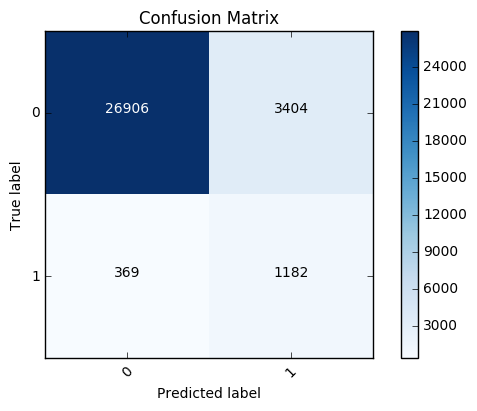

In [19]:
y_hat = [int(i>0.1) for i in pred]

cnf_matrix = confusion_matrix(y_tst, y_hat)
plot_confusion_matrix(cnf_matrix, classes=['0','1'], normalize=False)

## Plot partial dependence

In [51]:
def g_partial_dependence(model, X_trn, feature, grid=100, plot=True, output=False):
    """
    This function plots the partial dependence of a specific feature.
    If 'grid' is less than the number of feature levels, then use its real levels as the grid.
    """
    avg_prob = []
    lb = min(X_trn[feature])
    ub = max(X_trn[feature])
    if len(np.unique(X_trn[feature])) < grid:
        points = list(np.unique(X_trn[feature]))
    else:
        step = (ub-lb)/(grid-1)
        points = np.arange(lb, ub+step, step)
    X_trn_p = X_trn.copy()
    for p in points:
        X_trn_p.loc[:,feature] = p
        pred = model.predict_proba(X_trn_p)[:,1]
        avg_prob.append(np.mean(pred))
    if plot:
        plt.plot(points, avg_prob,'b')  
        plt.xlabel(feature)
        plt.ylabel('avg_prob')
        plt.show()
    if output:
        return list(points), avg_prob

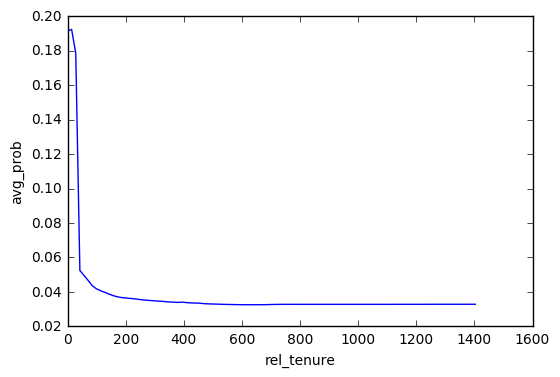

In [45]:
g_partial_dependence(RF_model, X_trn, 'rel_tenure', grid=100)

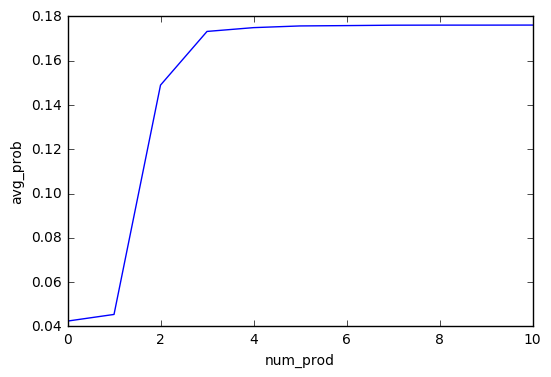

In [46]:
g_partial_dependence(RF_model, X_trn, 'num_prod', grid=50)

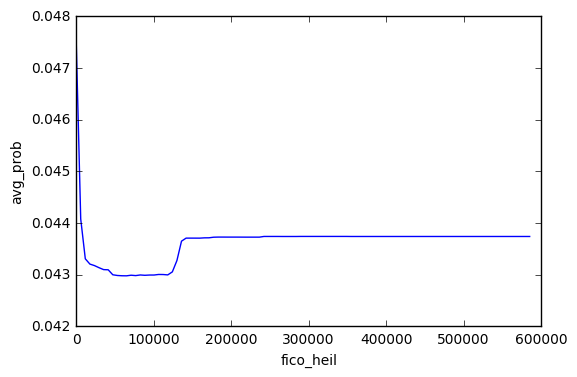

In [50]:
g_partial_dependence(RF_model, X_trn, 'fico_heil', grid=100)

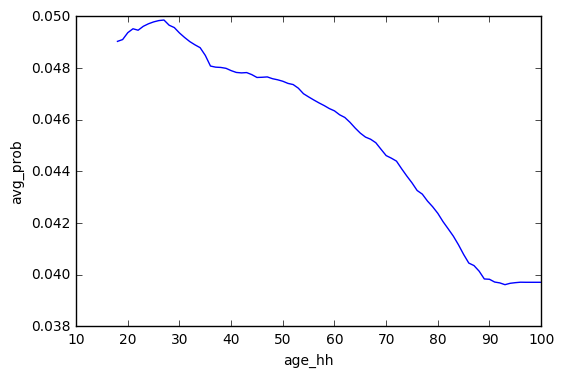

In [52]:
g_partial_dependence(RF_model, X_trn, 'age_hh', grid=100)

## Parameter Tuning
Tune hyperparameters using **exact** grid search or **random** grid search.

![alt text](https://www.analyticsvidhya.com/wp-content/uploads/2016/02/tree-infographic.png)

In [7]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
RF_model = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=100, n_jobs=-1)
param_grid = {"max_depth": [2,4,6,8,10,12,None],
              "max_features": [10,12,14,20,40,60,80,100],
              "min_samples_leaf": [1,2,3,4,5,6],
              "min_samples_split": [2,4,6,8,10,12],
              "bootstrap": [True, False]}
# grid_search = GridSearchCV(RF_model, param_grid=param_grid, scoring='roc_auc')
grid_search = RandomizedSearchCV(RF_model, param_distributions=param_grid, scoring='roc_auc', n_iter=30, n_jobs=-1)
start = time()
grid_search.fit(X_trn, y_trn)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

In [33]:
report(grid_search.cv_results_, n_top=5)

Model with rank: 1
Mean validation score: 0.924 (std: 0.001)
Parameters: {'min_samples_split': 2, 'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'max_features': 40}

Model with rank: 2
Mean validation score: 0.924 (std: 0.002)
Parameters: {'min_samples_split': 6, 'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'max_features': 20}

Model with rank: 3
Mean validation score: 0.919 (std: 0.001)
Parameters: {'min_samples_split': 10, 'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 6, 'max_features': 12}

Model with rank: 4
Mean validation score: 0.919 (std: 0.002)
Parameters: {'min_samples_split': 8, 'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 3, 'max_features': 10}

Model with rank: 5
Mean validation score: 0.917 (std: 0.001)
Parameters: {'min_samples_split': 6, 'bootstrap': False, 'max_depth': 12, 'min_samples_leaf': 5, 'max_features': 60}



Define a general function to output CV results.

In [6]:
def SearchCV(model, X_trn, y_trn, X_tst, y_tst, param_dict, scoring, n_iter=None):
    print('The base model is:\n', model.set_params())
    if n_iter == None:
        grid_search = GridSearchCV(model, param_grid=param_dict, scoring=scoring, n_jobs=-1)
        start = time()
        grid_search.fit(X_trn, y_trn)
        print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
              % (time() - start, len(grid_search.cv_results_['params'])))
    else:
        grid_search = RandomizedSearchCV(model, param_distributions=param_dict, scoring=scoring, n_iter=n_iter, n_jobs=-1)
        start = time()
        grid_search.fit(X_trn, y_trn)
        print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings."
              % (time() - start, len(grid_search.cv_results_['params'])))
    score_trn = []
    score_tst = []
    for param in grid_search.cv_results_['params']:
        model.set_params(**param)
        model.fit(X_trn, y_trn)
        pred_trn = model.predict_proba(X_trn)[:,1]
        pred_tst = model.predict_proba(X_tst)[:,1]
        if scoring == 'roc_auc':
            score_trn.append((round(roc_auc_score(y_trn, pred_trn), 5)))
            score_tst.append((round(roc_auc_score(y_tst, pred_tst), 5)))
    df_score = pd.DataFrame({'trn_score':score_trn, 'cv_score':list(grid_search.cv_results_['mean_test_score']), 'tst_score':score_tst})
    output = pd.concat([pd.DataFrame(list(grid_search.cv_results_['params'])), df_score], axis=1)
    return grid_search, output[list(param_dict.keys()) + ['trn_score','cv_score','tst_score']]     

Using "max_depth" to control tree complexity

In [7]:
RF_model = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=100, n_jobs=-1)
param_dict = {"max_depth": range(5,51),
              "max_features": range(15,85,5),
              "bootstrap": [True, False]}
grid_search, output = SearchCV(RF_model, X_trn, y_trn, X_tst, y_tst, param_dict, 'roc_auc', n_iter=30)
output.sort_values('tst_score', ascending=False)

The base model is:
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=100, verbose=0, warm_start=False)
RandomizedSearchCV took 5425.29 seconds for 30 candidate parameter settings.


,bootstrap,max_depth,max_features,trn_score,cv_score,tst_score
29,True,46,60,1.00000,0.920411,0.92027
16,True,44,55,1.00000,0.919815,0.92027
25,True,36,20,1.00000,0.919767,0.92022
15,True,47,65,1.00000,0.920056,0.92022
7,True,42,60,1.00000,0.919546,0.92021
17,False,44,25,1.00000,0.921162,0.91988
28,False,43,25,1.00000,0.920944,0.91981
19,True,31,35,1.00000,0.920394,0.91975
3,True,29,75,0.99989,0.919109,0.91941
12,True,28,30,0.99999,0.919396,0.91937


**More elaborate control** using "min_samples_split" and "min_samples_leaf"

In [8]:
RF_model = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=100, n_jobs=-1)
param_dict = {"max_features": range(15,85,5),
              "min_samples_leaf": [1,3,5,7,10,15,20,25,30,35,40],
              "min_samples_split": [2,4,6,8,10,15,20,25,30,35,40],
              "bootstrap": [True, False]}
grid_search, output = SearchCV(RF_model, X_trn, y_trn, X_tst, y_tst, param_dict, 'roc_auc', n_iter=30)
output.sort_values('tst_score', ascending=False)

The base model is:
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=100, verbose=0, warm_start=False)
RandomizedSearchCV took 5108.05 seconds for 30 candidate parameter settings.


,bootstrap,min_samples_split,max_features,min_samples_leaf,trn_score,cv_score,tst_score
9,True,4,40,7,0.99899,0.923723,0.92518
3,True,8,50,5,0.99954,0.924547,0.92493
1,False,20,40,10,0.99990,0.924396,0.92483
0,False,6,55,15,0.99942,0.923211,0.92369
23,False,20,30,3,1.00000,0.922704,0.92326
4,False,40,55,15,0.99908,0.923279,0.92309
13,False,20,55,25,0.99700,0.921367,0.92264
27,True,30,80,20,0.99148,0.921382,0.92256
25,False,35,20,7,0.99984,0.921214,0.92253
11,True,15,40,20,0.98970,0.920541,0.92235


## Getting the best model


In [9]:
bestclf = grid_search.best_estimator_
print(bestclf)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=50,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=5, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=100, verbose=0, warm_start=False)


In [10]:
pred = bestclf.predict_proba(X_tst)[:,1]
print(round(roc_auc_score(y_tst, pred), 6))

0.92493


# 2. Extremely Randomized Forest: an efficient alternative

In **random forests**, the node splitting rules are based on a best score resulting from selected features at each iteration. 

In **extremely randomized forests**, a random split is generated on each feature (so there are no computations spent on looking for the best split for each feature) and then the best feature is selected. 

In [46]:
RF_model = RandomForestClassifier(n_estimators=500, max_depth = 10, class_weight='balanced', random_state=100, n_jobs=-1)
start = time()
RF_model.fit(X_trn, y_trn)
RF_time = time() - start
pred = RF_model.predict_proba(X_tst)[:,1]
RF_auc = roc_auc_score(y_tst, pred)

In [47]:
ET_model = ExtraTreesClassifier(n_estimators=500, max_depth = 10, class_weight='balanced', random_state=100, n_jobs=-1)
start = time()
ET_model.fit(X_trn, y_trn)
ET_time = time() - start
pred = ET_model.predict_proba(X_tst)[:,1]
ET_auc = roc_auc_score(y_tst, pred)
print("Random Forest: time %.2f seconds, AUC %.5f." % (RF_time, RF_auc))
print("Extreme Forest: time %.2f seconds, AUC %.5f." % (ET_time, ET_auc))

Random Forest: time 9.15 seconds, AUC 0.89723.
Extreme Forest: time 5.82 seconds, AUC 0.87416.


# 3. More about (tuning) parameters
Enabling the parameter "class_weight" will result in "weighted" random forests. But the effect of "weights" in tree-based models seems unclear, people usually treat it as another tuning parameter in imbalanced datasets. 

#We also can define a function to help us. 
~~~~
def show_tuning(X_trn, X_tst, y_trn, y_tst, default_params, tuning_para, cand_values, cv=3, scoring='roc_auc', warm_start=False, chk_trn=True):
    clf = RandomForestClassifier(**default_params)
    trn_auc = []
    cv_auc = []
    tst_auc = []
    for n in cand_values:
        clf.set_params(**{tuning_para:n})
        if warm_start=True:
            clf.set_params(warm_start=True)
        clf.fit(X_trn, y_trn)
        cv_scores = cross_val_score(clf, X_trn, y_trn, cv=cv, scoring=scoring, n_jobs=-1)
        if chk_trn:
            pred_trn = clf.predict_proba(X_trn)[:,1]
        pred_tst = clf.predict_proba(X_tst)[:,1]
        cv_auc.append(np.mean(cv_scores))
        if chk_trn:
            trn_auc.append(roc_auc_score(y_trn, pred_trn))
        tst_auc.append(roc_auc_score(y_tst, pred_tst))
    return trn_auc, cv_auc, tst_auc
~~~~

## (1) Number of trees

In [58]:
RF_model = RandomForestClassifier(class_weight={0:len(y_trn)/sum(y_trn==0),1:len(y_trn)/sum(y_trn==1)}, 
                                  random_state=100, n_jobs=-1, warm_start=True)
RF_model.set_params(**{'min_samples_split': 2, 'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'max_features': 40})

RandomForestClassifier(bootstrap=True,
            class_weight={0: 1.0521995131064938, 1: 20.157266811279825},
            criterion='gini', max_depth=None, max_features=40,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=100, verbose=0, warm_start=True)

In [59]:
n_est_cand = np.linspace(50,1000,20)
n_est_cv_auc = []
n_est_trn_auc = []
n_est_tst_auc = []
for n in n_est_cand:
    RF_model.set_params(n_estimators=int(n), warm_start=True)
    RF_model.fit(X_trn, y_trn)
    cv_scores = cross_val_score(RF_model, X_trn, y_trn, cv=3, scoring='roc_auc', n_jobs=-1)
    pred_trn = RF_model.predict_proba(X_trn)[:,1]
    pred_tst = RF_model.predict_proba(X_tst)[:,1]
    n_est_cv_auc.append(np.mean(cv_scores))
    n_est_trn_auc.append(roc_auc_score(y_trn, pred_trn))
    n_est_tst_auc.append(roc_auc_score(y_tst, pred_tst))

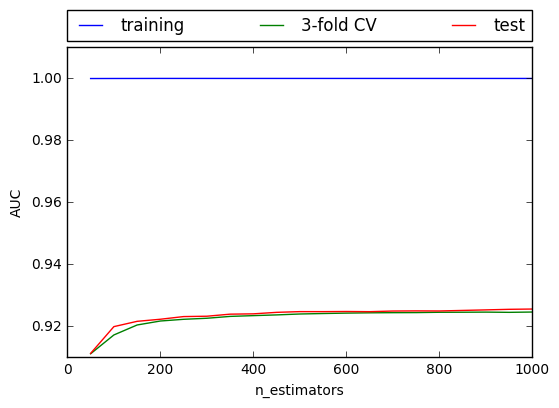

In [79]:
plt.plot(n_est_cand, n_est_trn_auc,'b', label='training')  
plt.plot(n_est_cand, n_est_cv_auc, 'g', label='3-fold CV') 
plt.plot(n_est_cand, n_est_tst_auc,'r', label='test') 
plt.ylim((0.91,1.01))
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
plt.show()

Since all the training auc's are very close to 1, we delete them.

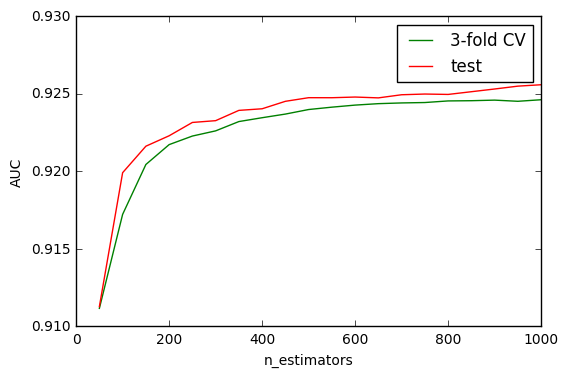

In [89]:
plt.plot(n_est_cand, n_est_cv_auc, 'g', label='3-fold CV') 
plt.plot(n_est_cand, n_est_tst_auc,'r', label='test') 
plt.ylim((0.91,0.935))
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.legend()
plt.show()

## (2) Tree depth

In [10]:
RF_model = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=100, n_jobs=-1)

depth_cand = np.linspace(2,60,30)
depth_cv_auc = []
depth_tst_auc = []
depth_trn_auc = []
for n in depth_cand:
    RF_model.set_params(max_depth=int(n))
    RF_model.fit(X_trn, y_trn)
    cv_scores = cross_val_score(RF_model, X_trn, y_trn, cv=3, scoring='roc_auc', n_jobs=-1)
    pred_trn = RF_model.predict_proba(X_trn)[:,1]
    pred_tst = RF_model.predict_proba(X_tst)[:,1]
    depth_cv_auc.append(np.mean(cv_scores))
    depth_trn_auc.append(roc_auc_score(y_trn, pred_trn))
    depth_tst_auc.append(roc_auc_score(y_tst, pred_tst))

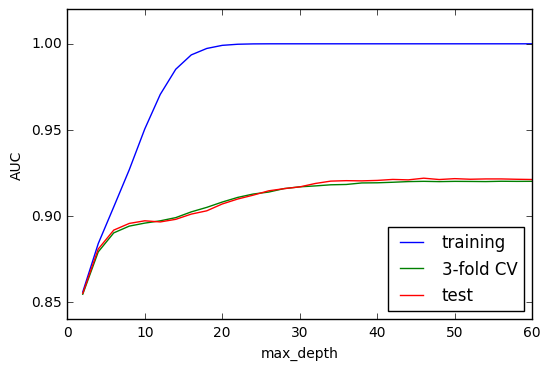

In [11]:
plt.plot(depth_cand, depth_trn_auc, 'b', label='training') 
plt.plot(depth_cand, depth_cv_auc, 'g', label='3-fold CV') 
plt.plot(depth_cand, depth_tst_auc,'r', label='test') 
plt.xlabel('max_depth')
plt.ylabel('AUC')
plt.legend(loc=4)
plt.show()

## (3) Max number of features

In [13]:
RF_model = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=100, n_jobs=-1)

fea_cand = np.linspace(5,80,16)
fea_trn_auc = []
fea_cv_auc = []
fea_tst_auc = []
for n in fea_cand:
    RF_model.set_params(max_features=int(n))
    RF_model.fit(X_trn, y_trn)
    cv_scores = cross_val_score(RF_model, X_trn, y_trn, cv=3, scoring='roc_auc', n_jobs=-1)
    pred_trn = RF_model.predict_proba(X_trn)[:,1]
    pred_tst = RF_model.predict_proba(X_tst)[:,1]
    fea_cv_auc.append(np.mean(cv_scores))
    fea_trn_auc.append(roc_auc_score(y_trn, pred_trn))
    fea_tst_auc.append(roc_auc_score(y_tst, pred_tst))

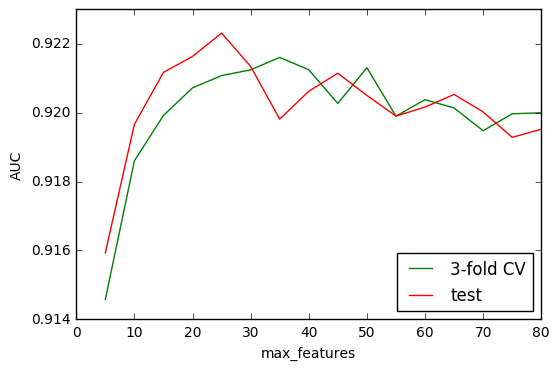

In [17]:
# plt.plot(fea_cand, fea_trn_auc, 'b', label='training') 
plt.plot(fea_cand, fea_cv_auc, 'g', label='3-fold CV') 
plt.plot(fea_cand, fea_tst_auc,'r', label='test') 
plt.xlabel('max_features')
plt.ylabel('AUC')
plt.legend(loc=4)
plt.show()

# 4. Subsampling for big data

Both "RandomForest" and "ExtraTrees" support *warm_start*, which enables us to

  >(1) train a forest sequentially (as shown in Sec 3(1)),

  >(2) train an ensembled forest with some online/mini-batch flavor.

(2) will be helpful for large-scale datasets (impossible to fit in the memory). Of course, we have to use some memory-efficient sampling algorithm.

In [23]:
X_trn_pos = X_trn.loc[y_trn==1,]
y_trn_pos = y_trn.loc[y_trn==1]

In [24]:
X_trn_pos.shape, y_trn_pos.shape

((3688, 194), (3688,))

In [ ]:
X_trn_neg = X_trn.loc[y_trn==0,]
y_trn_neg = y_trn.loc[y_trn==0]

Subsampling: we divide the whole dataset into 3 subsets. 

Due to the imbalance, we require each subset to contain all the positive observations.

In [71]:
batches = 3
trees_per_batch = 200

start = time()
n_neg = X_trn_neg.shape[0]
tst_auc = []
clf = RandomForestClassifier(n_jobs=-1, warm_start=True)
clf.set_params(**{'min_samples_split': 2, 'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'max_features': 40})
for i in range(batches):
    X_trn_sub = pd.concat([X_trn_pos, X_trn_neg.iloc[i*int(n_neg/batches):(i+1)*int(n_neg/batches),]])
    y_trn_sub = pd.concat([y_trn_pos, y_trn_neg.iloc[i*int(n_neg/batches):(i+1)*int(n_neg/batches),]])
#     X_trn_sub = X_trn.iloc[i*int(n_neg/batches):(i+1)*int(n_neg/batches),]
#     y_trn_sub = y_trn.iloc[i*int(n_neg/batches):(i+1)*int(n_neg/batches),]
    clf.set_params(n_estimators=(i+1)*trees_per_batch, warm_start=True, class_weight={0:len(y_trn_sub)/sum(y_trn_sub==0),1:len(y_trn_sub)/sum(y_trn_sub==1)})
    clf.fit(X_trn_sub, y_trn_sub)
    pred_tst = clf.predict_proba(X_tst)[:,1]
    tst_auc.append(roc_auc_score(y_tst, pred_tst))
    print(str(i+1)+" test AUC:", tst_auc[i],", total time:", time()-start)

1 test AUC: 0.921075407975 , total time: 5.586766958236694
2 test AUC: 0.923225583648 , total time: 11.699950218200684
3 test AUC: 0.923534023345 , total time: 18.07475781440735
